In [1]:
import datetime
import pandas as pd
import json
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('talk')
from statsmodels.tsa import stattools
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 6)

Populating the interactive namespace from numpy and matplotlib


# Part    1    ‑    Exploratory    data    analysis
The    attached       logins.json       file     contains     (simulated)     timestamps    of    user     logins     in    a    particular  geographic     location.     Aggregate     these     login     counts    based    on    15­ minute     time     intervals,    and  visualize     and    describe     the     resulting     time     series    of     login     counts     in    ways     that    best     characterize     the  underlying    patterns     of     the    demand.     Please     report/illustrate     important     features    of     the    demand,  such     as    daily     cycles.     If     there     are     data     quality     issues,    please     report     them. 


In [2]:

data = pd.read_json('logins.json','r',convert_dates = True)
data = data.set_index('login_time')
data['log_in'] = 1
data.sort_index()
data.head()

,log_in
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Data columns (total 1 columns):
log_in    93142 non-null int64
dtypes: int64(1)
memory usage: 1.4 MB


In [4]:
#aggregate into 15min intervals
d_15 = data.resample('15min', label = 'left').sum()
d_15.head()

,log_in
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


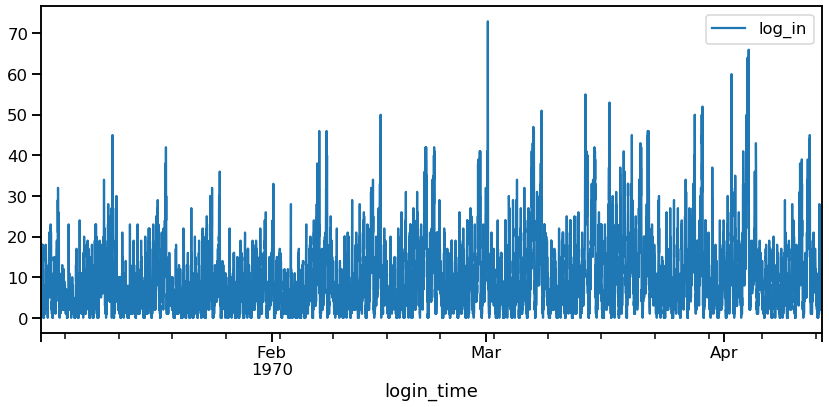

In [5]:
#preview the data
d_15.plot(kind= 'line', figsize = (14,6))
plt.show()

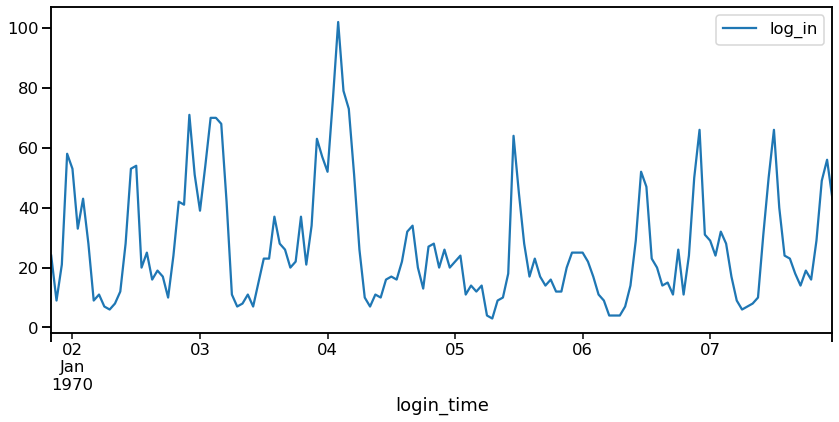

In [6]:
#get an overview of the data, hourly, over the course of one week
d = data.resample('60T', label = 'left').count()
d.loc['1970-01-01':'1970-01-07' ].plot(figsize = (14,6))

In [7]:
# add in the day of the week
d_15['day'] = [datetime.datetime.strftime(x, "%a") for x in d_15.index]
d_15.head()

,log_in,day
login_time,,
1970-01-01 20:00:00,2,Thu
1970-01-01 20:15:00,6,Thu
1970-01-01 20:30:00,9,Thu
1970-01-01 20:45:00,7,Thu
1970-01-01 21:00:00,1,Thu


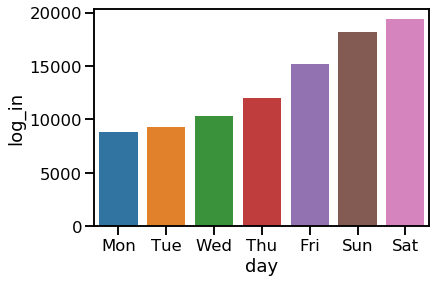

In [8]:
#weekly view of logins per day of the week
weekly = d_15.groupby('day').sum().sort_values(by = 'log_in').reset_index()
_=sns.barplot(x = 'day', y = 'log_in', data = weekly)

In [9]:
def day_of_week(row):
    '''function to add in a weekday or weekend label'''
    if row['day'] in ['Sat', 'Sun']:
        return 'Weekend'
    else:
        return 'Weekday'

In [10]:
# add a column of 'hour'
d_15['hour'] = [datetime.datetime.strftime(x, "%H:%M:%S") for x in d_15.index]
#add in a weekday or weekend label
d_15['day_type'] = d_15.apply(day_of_week, axis = 1)

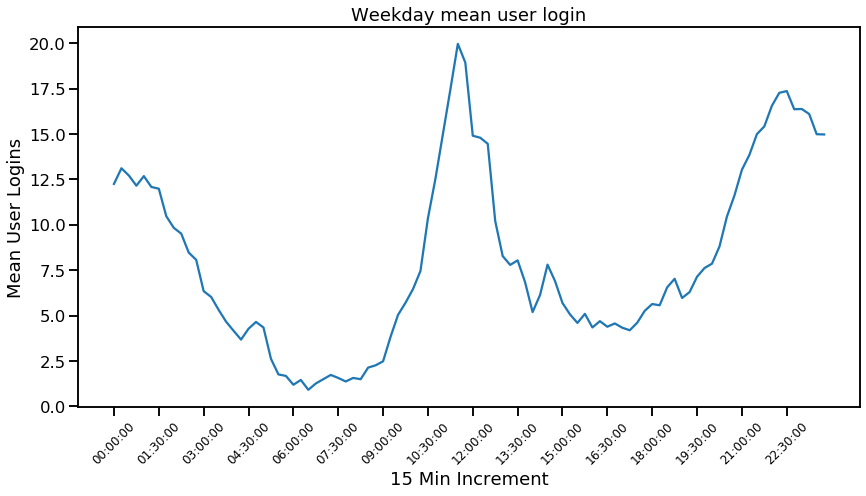

In [11]:
#aggregate data for a mean weekday by 15min interval
weekday = d_15.groupby(['day_type','hour']).mean().loc['Weekday']
fig = plt.figure(figsize = (14, 7))
plt.plot(weekday)
locs, labels = xticks()
plt.xlabel('15 Min Increment')
plt.ylabel('Mean User Logins')
plt.title('Weekday mean user login')
labelss = d_15.groupby(['day_type','hour']).mean().loc['Weekday'].index[0::6]
plt.xticks(locs[::6], labelss, rotation = 45, fontsize = 'large')
plt.show()

For weekdays there appears to be a peak around 11:30am, and second more gradual and longer peak  in the late afternoon. This second peak may be split into two peaks around 10pm with a smaller peak around 1230am. 

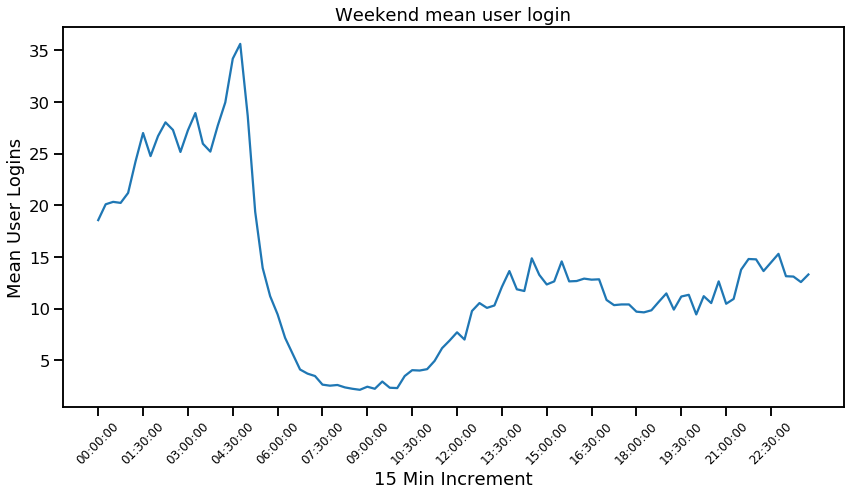

In [12]:
#aggregate data for a mean weekend by 15min interval
weekday = d_15.groupby(['day_type','hour']).mean().loc['Weekend']
fig = plt.figure(figsize = (14, 7))
plt.plot(weekday)
locs, labels = xticks()
plt.xlabel('15 Min Increment')
plt.ylabel('Mean User Logins')
plt.title('Weekend mean user login')
labelss = d_15.groupby(['day_type','hour']).mean().loc['Weekend'].index[0::6]
plt.xticks(locs[::6], labelss, rotation = 45, fontsize = 'large')
plt.show()

For Weekends (Saturday/Sunday) there is a large peak around 430 AM, with a very steep dip at around 545AM. Logins gradually start rising to a peak of 10-15 logins every 15minutes from 1:30PM to 11:00PM.

In [13]:
df = data.reset_index()
df['day'] = df.login_time.apply(lambda x:datetime.datetime.strftime(x, "%a"))
df['time_delta'] = df.login_time.apply(lambda x:pd.to_timedelta(str(datetime.datetime.strftime(x, '%H:%M:%S'))))
df['ns'] = df.login_time.apply(lambda x:pd.Timedelta.to_timedelta64(pd.to_timedelta(str(datetime.datetime.strftime(x, '%H:%M:%S')))))
df['day_type'] = df.apply(day_of_week, axis = 1)
df.head()

,login_time,log_in,day,time_delta,ns,day_type
0,1970-01-01 20:13:18,1,Thu,20:13:18,20:13:18,Weekday
1,1970-01-01 20:16:10,1,Thu,20:16:10,20:16:10,Weekday
2,1970-01-01 20:16:37,1,Thu,20:16:37,20:16:37,Weekday
3,1970-01-01 20:16:36,1,Thu,20:16:36,20:16:36,Weekday
4,1970-01-01 20:26:21,1,Thu,20:26:21,20:26:21,Weekday


In [14]:
#peaks for weekdays and weekends
peaks = {'Weekday 1' : 'wd1', 'Weekday 2' : 'wd2','Weekday 3' : 'wd3','Weekend 1' : 'we',}


#set an arbitrary date to be able to subtract the times of different days
temp_date = pd.Timedelta.to_timedelta64(pd.to_timedelta(str(datetime.datetime.strftime(data.index[0], '%H:%M:%S'))))

df = df.set_index('login_time')

day_rng = pd.date_range(start = df.iloc[0].name.strftime('%Y-%m-%d'), end = df.iloc[-1].name.strftime('%Y-%m-%d'))
day_rng = day_rng.delete([0,(len(day_rng)-1)])


In [15]:



def list_of_means(df, day_rng, peak, weekend = 0):
    '''generates a list of times for a specified peak during the weekday or weekend'''
    top_dates = []
    df_2 = df.copy(deep = True)
    if peak not in ['wd1','wd2','wd3']: weekend = 1
    for day in day_rng:
        if day != datetime.datetime.strptime('1970-01-01', '%Y-%m-%d') or day != datetime.datetime.strptime('1970-04-13', '%Y-%m-%d'):
            tmp = df_2.loc[datetime.datetime.strftime(day, '%Y-%m-%d')]
            if peak not in ['wd1','wd2','wd3'] : weekend = 1
            if tmp['day_type'].any() == 'Weekday' and weekend == 0:
                if peak == 'wd2':
                    day_mean = tmp[(tmp.time_delta > pd.to_timedelta('09:00:00')) & (tmp.time_delta<pd.to_timedelta('13:30:00'))].time_delta.values.mean()
                    top_dates.append(day_mean)
                if peak == 'wd3':
                    day_mean = tmp[tmp.time_delta > pd.to_timedelta('19:30:00')].time_delta.values.mean()
                    top_dates.append(day_mean)
                if peak == 'wd1':
                    day_mean = tmp[tmp.time_delta < pd.to_timedelta('04:30:00')].time_delta.values.mean()
                    top_dates.append(day_mean)
            if tmp['day_type'].any() == 'Weekend' and weekend == 1:
                day_mean = tmp[(tmp.time_delta > pd.to_timedelta('03:45:00')) & (tmp.time_delta<pd.to_timedelta('05:30:00'))].time_delta.values.mean()
                top_dates.append(day_mean)
    return top_dates
    
def top_means(row, avg):
    '''function to convert the year, month, day to an arbitrary day for all datetimes, with the recorded hour, min, seconds'''
    d_avg = pd.to_datetime(pd.Timedelta.to_timedelta64(row['day_avg']))
    ns_avg = pd.to_datetime(avg)
    n_time = (str(ns_avg.year)+'-'+str(ns_avg.month)+'-'+str(ns_avg.day)+' '+str(d_avg.time().hour)+':'+str(d_avg.time().minute)+':'+str(d_avg.time().second))
    d_n_time = datetime.datetime.strptime(n_time, '%Y-%m-%d %H:%M:%S')
    return(d_n_time)

def convert_days(ls_means):
    '''convert the datetime for each row in the dataframe'''
    df = pd.DataFrame({'day_avg':ls_means})
    df['converted_date'] = df.apply(top_means, avg = temp_date, axis = 1)
    return(df['converted_date'])

def bootstrap_replicate_1d(data):
    '''generate bootstrap replicate of 1D data'''
    bs_sample = np.random.choice(data, len(data))
    bs_sample = pd.Series(bs_sample)
    return bs_sample.mean()

def draw_bs_reps(data, size = 1):
    '''draw bootstrap replicates'''
    bs_replicates = list()
    for i in range(size):
        bs_rep = bootstrap_replicate_1d(data)
        bs_replicates.append(bs_rep)
    return np.asarray(bs_replicates)
    
def conf_int(data, size = 1):
    '''generates the confidence interval from the bs_reps'''
    bs_replicates = draw_bs_reps(data, size)
    bs_replicates = np.asarray([pd.Timedelta.to_timedelta64(pd.to_timedelta(str(datetime.datetime.strftime(x, '%H:%M:%S')))) for x in bs_replicates])
    conf_int = np.percentile(bs_replicates, [2.5, 97.5])
    return(datetime.datetime.strftime(pd.to_datetime(conf_int[0]),'%H:%M:%S' ), datetime.datetime.strftime(pd.to_datetime(conf_int[1]),'%H:%M:%S' ))
    


In [16]:


for peak, code in peaks.items():
    ci = conf_int(convert_days(list_of_means(df, day_rng, code)), 1000)
    print('95% confidence = the {} peak time will be between {} and {}'.format(peak, ci[0], ci[1]))


C:\Users\Bryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
C:\Users\Bryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
C:\Users\Bryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version


95% confidence = the Weekday 1 peak time will be between 01:45:17 and 01:49:23
95% confidence = the Weekday 2 peak time will be between 11:33:32 and 11:36:15
95% confidence = the Weekday 3 peak time will be between 22:00:54 and 22:04:07
95% confidence = the Weekend 1 peak time will be between 04:35:18 and 04:37:44


**Note**: Similar analysis can be performed with:
- avg riders during peak ('*How many logins can be expected during peak times?*')
- the time when logins increase >20% prior to peak ('*When should driver partners be logged in and available prior to peak logins?*')

# Part    2    ‑    Experiment    and    metrics    design 
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. 

However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have  proposed an experiment to encourage driver partners to be available in both cities, by  reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in  encouraging driver partners to serve both cities, and why would you choose this metric?  
2. Describe a practical experiment you would design to compare the effectiveness of the  proposed change in relation to the key measure of success. Please provide details on: 
        a. how you will implement the experiment  
        b. what statistical test(s) you will conduct to verify the significance of the  observation  
        c. how you would interpret the results and provide recommendations to the city  operations team along with any caveats

### Answer 1: 
I would investigate further to determine the best metric. The ultimate goal is to increase revenue. This equates to more rides completed, less wait times for each rider, and a positive experience. 

If driver partners are tending to be 'exclusive' to each city - I would investigate ***how*** a drive partner could accomplish this. If a driver partner is screening a ride or canceling a ride,  a possible metric could be the number of rides cancelled by a driver per driving session. I would also need to find out what other reasons a driver would have to cancel a ride. 

Possible metrics:
-  **# driver initiated canceled rides per session**, where the destination city was Gotham and the origin was Metropolis (or vice versa)
    - Session is a predetermined number of rides, either a typical/average # of rides per driver per work session or some other standard
-  **Wait times for riders**, where the destination city was Gotham and the origin was Metropolis (or vice versa)
    - this can be used for data driven insights back to the Ultimate managers. The assumption is, if drivers are not canceling (or staying in their city) than more drivers would be available to make the trip, reducing the time
- **Net Promoter Score** track the ratings of drivers, and analyze feedback, where the destination city was Gotham and the origin was Metropolis (or vice versa)

Supporting metrics to track:
- **Total Fare**, where the destination city was Gotham and the origin was Metropolis (or vice versa)
    - Can be used to potentially share back to driver partners how much a typical fare across the bay
- **Total Number of Rides**
    - With more drivers crossing between cities, is there an increase in rides total?
- **Total Fare**
    - With more drivers crossing between cities, is there an increase in Fares?
- **Total Tolls Reimbursed**
    - With more drivers crossing between cities, what is the total cost of reimbursement?
- **+/- Profit**
    - With more drivers crossing between cities, what is the net profit?

### Answer 2: 
I would calcualte the key metric for all riders (# of canceled rides or Net Promoter Score), wait time for riders is not driver parner focused). Then rank drivers and pick a focus group from each quartile. I would split the focus group into test and control groups ensuring each split consisted of similar number attributed (ie. number of rides given per session, time of day driven etc.)

The test group would be informed of the changes (toll reimbursement).

After conclusion of the test time period, I would run a permutation bootstrap test to test the hypothesis that there was no change in the key metric of choice between the two groups for each quartile. If there was a statistical & practical significant difference between the two groups, I would analyze the supporting metrics. I would give my recommendations to the Ultimate managers with any caveates found in the data. 

For example, if there was a difference was the key metric, did this equate to more riders? 

How much in tolls were reimbursed? 

What is the potential cost? 

Did the highest and lowest quartiles not differ, but the mid quartiles did improve? 

Was there a difference between weekend and weeday performance? 

If so, this be presented as a weekend benefit/offer. etc.

# Part    3    ‑    Predictive     modeling 
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand ***what factors are the best predictors
for retention***, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

In [17]:
file = open('./ultimate_data_challenge.json')
data = pd.DataFrame(json.load(file))
file.close()

In [18]:
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


**Notes:**

The date columns will need to be converted to datetimes for further analysis

The ultimate_black_user column will need to be converted to an int for the classifier

In [20]:
def conv_to_datetime(row, col):
    return pd.to_datetime(row[col])

In [21]:
date_cols = ['signup_date', 'last_trip_date']

for col in date_cols:
    data[col] = data.apply(conv_to_datetime, col = col, axis = 1)

data['ultimate_black_user'] = data['ultimate_black_user'].astype('int')

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null int32
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: datetime64[ns](2), float64(6), int32(1), int64(1), object(2)
memory usage: 4.4+ MB


In [23]:
data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,0.37708,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,0.48466,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,0.00000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,0.00000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,1.00000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,1.00000,100.000000,160.960000,5.000000


In [24]:
data[data.trips_in_first_30_days <50].describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
count,49985.000000,41863.000000,49985.000000,49985.000000,49985.000000,49985.000000,49985.000000,49784.000000
mean,2.260338,4.601529,1.074774,8.850809,0.376933,60.921713,5.797664,4.778176
std,3.636891,0.617423,0.222368,19.961554,0.484623,37.086009,5.707979,0.446710
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,1.000000,100.000000,6.940000,5.000000
max,49.000000,5.000000,8.000000,100.000000,1.000000,100.000000,160.960000,5.000000


In [25]:
def plot_ecdf(data, col):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    _=plt.plot(x, y, marker = '.', linestyle = 'none')
    _=plt.title(col)
    plt.show()

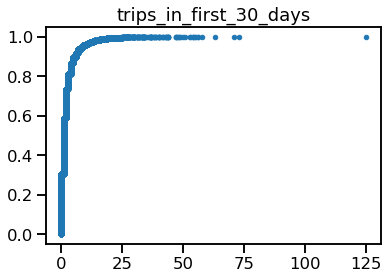

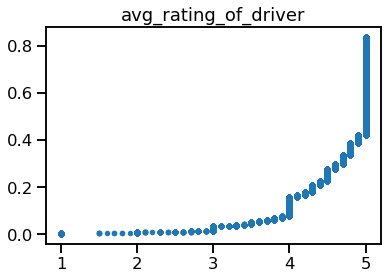

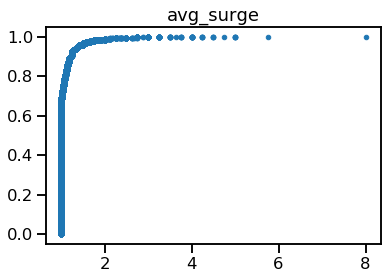

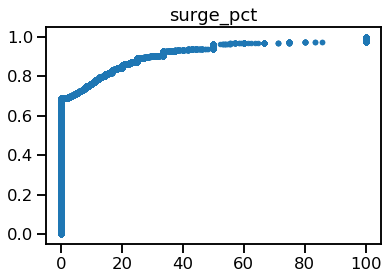

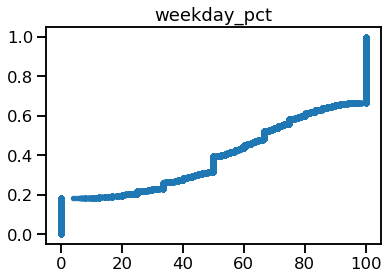

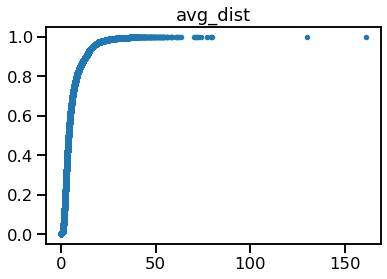

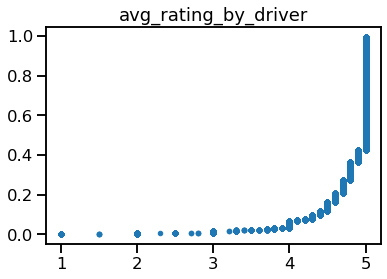

In [26]:
cols = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge','surge_pct',
        'weekday_pct', 'avg_dist', 'avg_rating_by_driver']
for col in cols:
    plot_ecdf(data[col], col)

From the columns explored, it appears there is a smaller percentage of 'super riders'. For example, trips_in_first_30_days, ~90% of riders, have 10 or less trips, however there remaining 5% range from 10-120 miles. 

Avg_surge, we see the same, ~ 95% of riders have an average surge of <1.3, however the remaining 5% range from 1.3 - 8.

avg_dist again shows the same, ~95% of riders, ride 18miles or less/trip. While the remaining 5% ranges from 18-160miles/trip

Weekday_pct, interesting that 20% of users only use Ultimate during the weekend.


In [27]:
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9


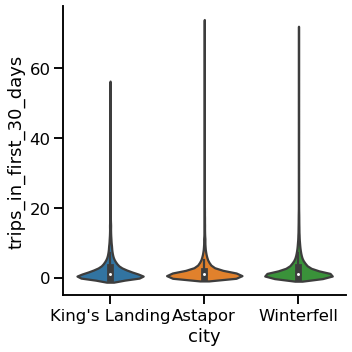

In [28]:
df = data[data.trips_in_first_30_days <100]
sns.catplot(x = 'city', y = 'trips_in_first_30_days',kind = 'violin', data = df)

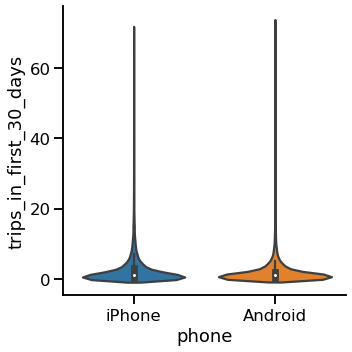

In [29]:
sns.catplot(x = 'phone', y = 'trips_in_first_30_days',kind = 'violin', data = df)

**Generate the target variable** - 'active users'
Active users will be found by determining their 6th month from joining and verifying if their last trip date is one month or less than their start date.

In [30]:
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9


In [31]:
def active_user(row):
    sixth_month = pd.to_timedelta('180D')
    thresh = pd.to_timedelta('30D')
    monitor_point = row['signup_date'] + sixth_month
    prev_month_test = monitor_point - thresh
    active_rider = prev_month_test <= row['last_trip_date'] <= monitor_point
    if active_rider == True:
        return 1
    else:
        return 0
    
def weekday_riders(row):
    if row['weekday_pct'] > .85:
        return 1
    else:
        return 0

def weekend_riders(row):
    if row['weekday_pct'] < .15:
        return 1
    else:
        return 0

In [32]:
data['active_user'] = data.apply(active_user, axis = 1)
#create two new features, the majority of weekend & weekday riders
data['weekend_riders'] = data.apply(weekend_riders, axis = 1)
data['weekday_riders'] = data.apply(weekday_riders, axis = 1)

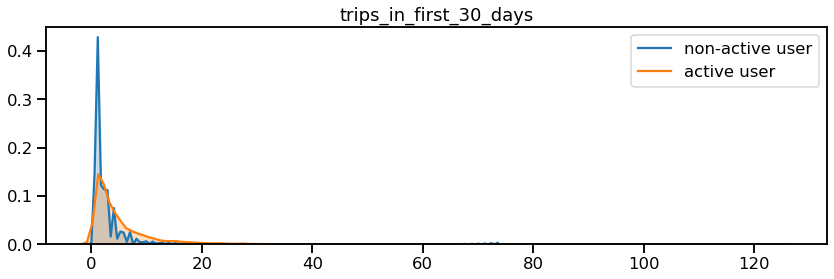

C:\Users\Bryan\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Bryan\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


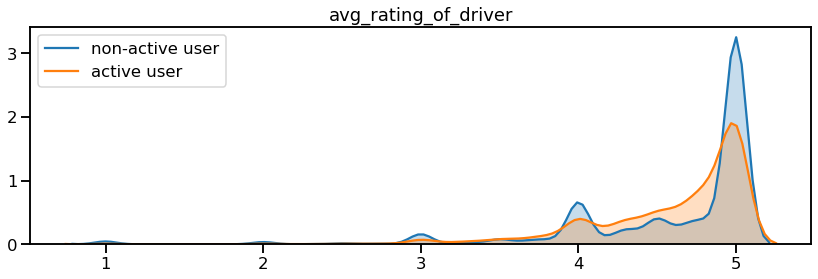

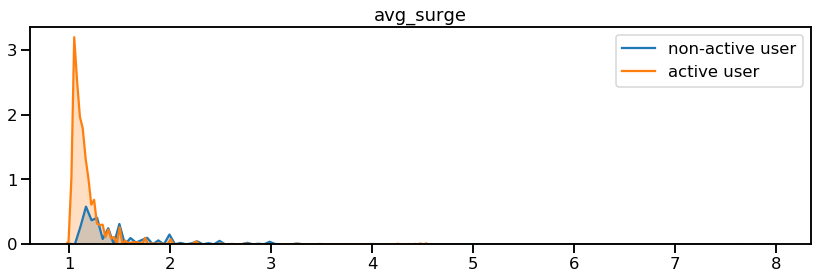

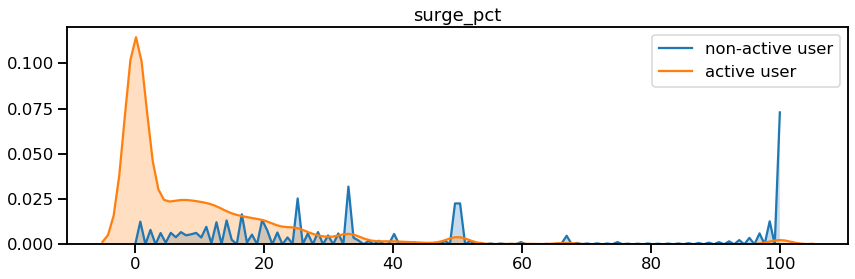

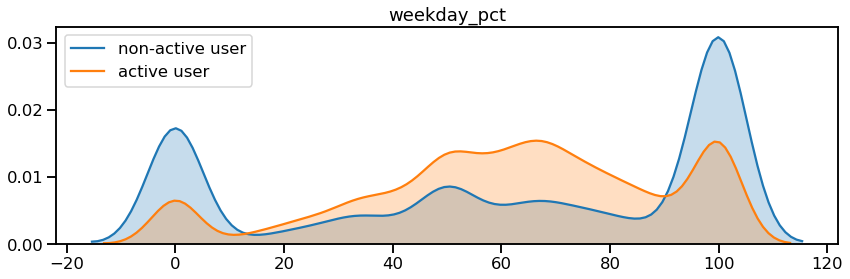

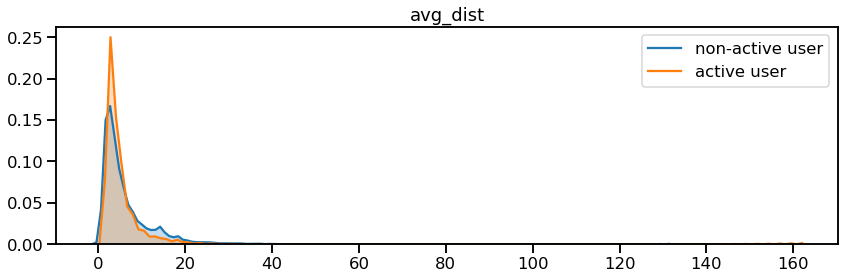

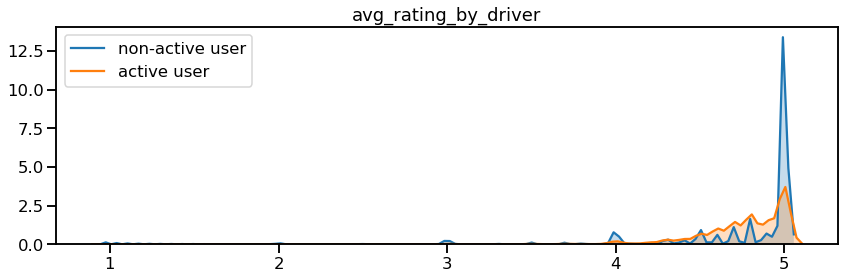

In [33]:
for col in ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge','surge_pct',
        'weekday_pct', 'avg_dist', 'avg_rating_by_driver']:
    fig = plt.figure(figsize = (14, 4))
    for i in np.arange(2):
        if i == 0: 
            label = 'non-active user'
        else:
            label = 'active user'
        sns.kdeplot(data[data.active_user == i][col], label = label, shade = True)
    plt.title(col)
    plt.show()

In [34]:
data.active_user.value_counts(normalize = True)

0    0.74598
1    0.25402
Name: active_user, dtype: float64

### 25% of users from January 2014 were retained 6 months later

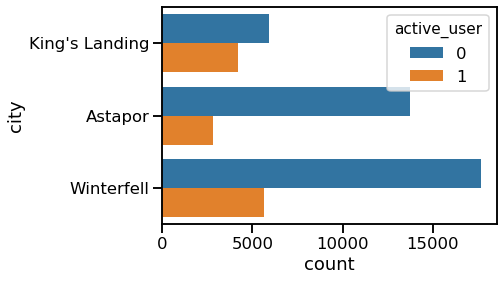

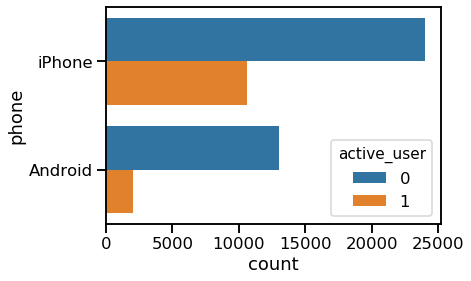

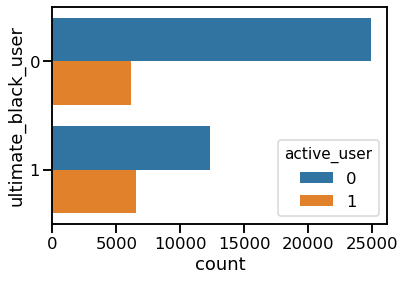

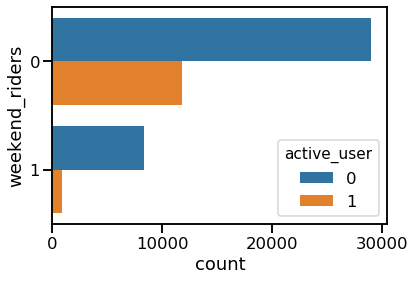

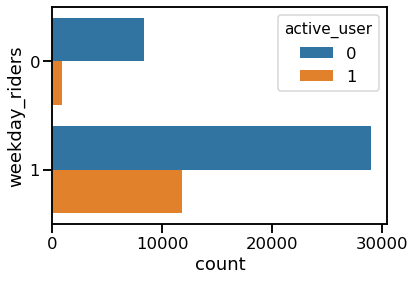

In [36]:
for col in ['city','phone','ultimate_black_user', 'weekend_riders', 'weekday_riders']:
    sns.countplot(y = col, hue = 'active_user', data = data )
    plt.show()


It appears there may be higher active users with:
- Riders that are from Kings Landing
- iPhone users
- Ultimate Black Users
- Weekday riders

Convert the categorical variables to dummy variables

In [37]:
df = pd.concat([data, pd.get_dummies(data['city']), pd.get_dummies(data['phone'], drop_first = True)], axis=1) 
df.drop(columns = ['city','phone', 'signup_date','last_trip_date'], inplace=True)
df.rename(columns ={'Astapor':'apstapor',"King's Landing":'k_landing',
                     'Winterfell':'winterfell', 'iPhone': 'iphone'}, inplace = True )

In [38]:
#eliminate outliers in the designated columns

cols = ['avg_surge', 'trips_in_first_30_days', 'avg_dist', 'surge_pct']

#eliminate the top .01% of data from the selected columns (outliers) 
for col in cols:
    elim = np.percentile(df[col], 99.9) 
    df = df[df['avg_surge'] <= elim]

C:\Users\Bryan\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Bryan\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


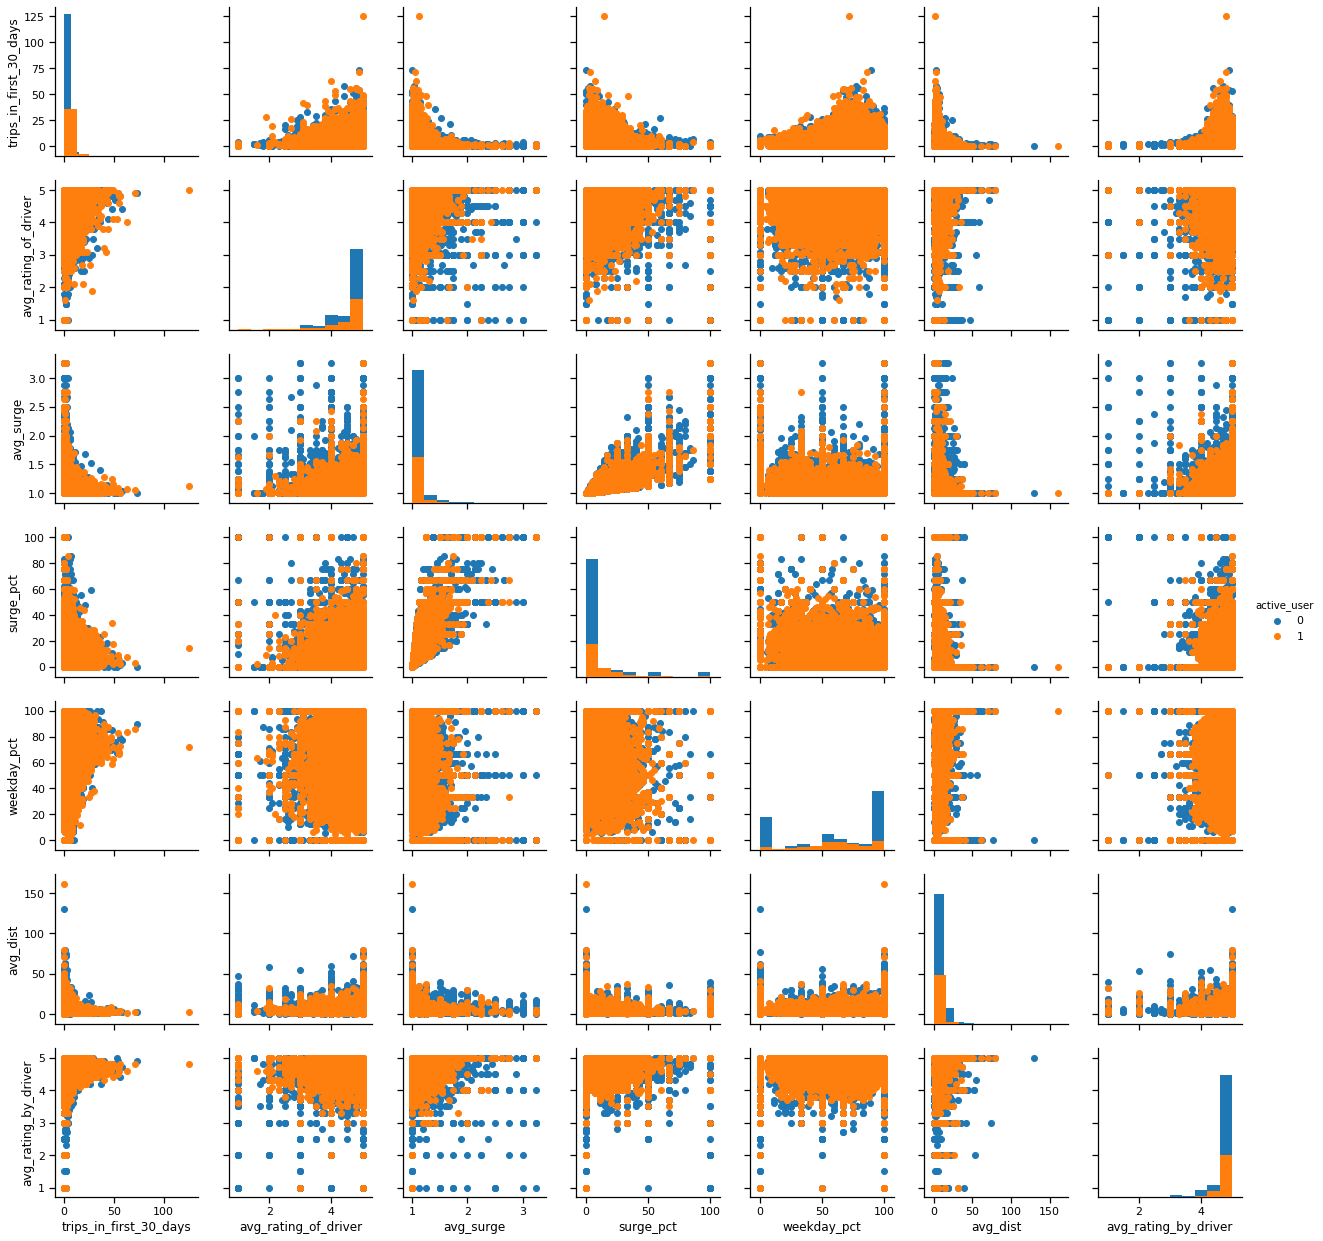

In [39]:
sns.set_context('notebook')
p = sns.PairGrid(df,
                 x_vars = ['trips_in_first_30_days','avg_rating_of_driver', 'avg_surge',
                           'surge_pct', 'weekday_pct', 'avg_dist',
                           'avg_rating_by_driver'],
                 y_vars = ['trips_in_first_30_days','avg_rating_of_driver', 'avg_surge',
                           'surge_pct','weekday_pct', 'avg_dist',
                           'avg_rating_by_driver'],
                 hue = 'active_user'
                )
p = p.map_diag(plt.hist)
p.map_offdiag(plt.scatter)
p.add_legend()

The average rating features are interesting here, it seems that for nearly every feature, when compared to one of the rating features, the active users are more condensed, with slightly less variability than non active users. 

For instance, when looking at rating of the driver and avg surge, the active users are plotted more closley near higher ratings of the drivers and lower avg_surge. Suggesting that active users utilize Ultimate during non-surge times more often than non-active users, and also give higher driver ratings. This makes sense, if active users use Ultimate more during the week, when there is less of a wait time, and less of an opporutnity to encounter surge pricing.

Active users seem to utilize Ultimate during the week and weekends, where non-active users seem to utilize Ultimate either primarily during the weekends or during the week. 

It would seem that Active users, utilize Ultimate for shorter drives, throughout many days of the week, during lesser surge times. It seems it is utilized more as a way to get around. Vs Non-active users that utilize Ultimate during long drives, during higher surge periods. This may suggest that Non-Active users use Ultimate during a high commute times. Weekends, to/from and event (social gathering, airport, sporting event) - less frequent intances.


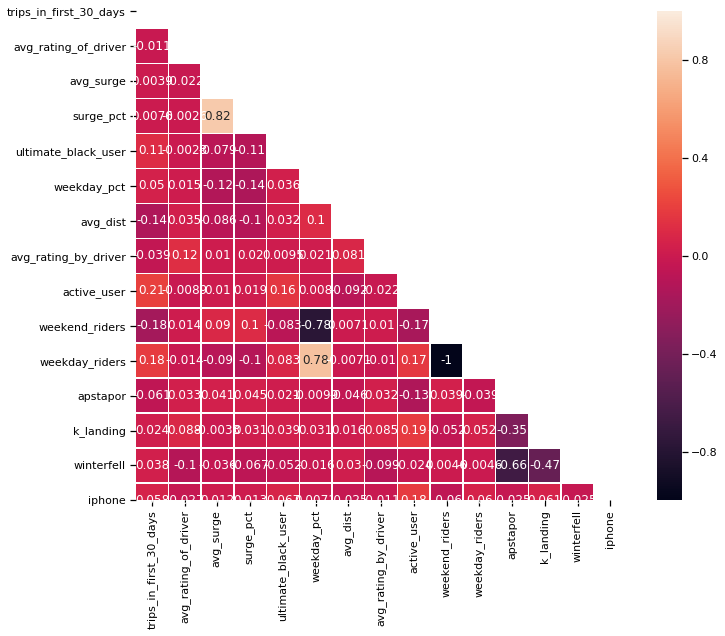

In [40]:
#generate correlation
corr = df.corr()

#create a mask for the upper triangles
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize = (11, 9))

sns.heatmap(corr, mask = mask, linewidths = .5, annot = True )

The heat map shows that active users have slight correlation with (descening order)trips in the first 30 days,Kings Landing users, iPhone users, weekday riders, ultimate black users. 

A few of these will be useful when making recommendations, for example first 30 days, weekday riders & ultimate black users. Those can be focused on from an operations standpoint. 

Kings Landing Users, and iPhone users are a bit more trickier...***why*** are iPhone users more likely to be retained? Is it how quick the app comes up? UI? Same with Kings Landing, do we just accept that riders from winterfell or astapor have a lower rate of being retained? More information would be needed to dig into 'why' for these features.

It appears there are slightly higher correlation with weekday riders in Kings Landing than the other two cities, and there is also a slightly higher correlation with avg rating of the driver. Are rides more pleasant in Kings Landing?

In [41]:
#import relevent classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

#import preprocessing, metrics & pipelines
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score


In [42]:
#set up the target variable
y = df['active_user'].values


#set the x variables
X = df.drop(['active_user'], axis = 1)


In [43]:
#split the data to test & training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 5, stratify = y)


#build the pipline with upsampling & scaling the data
pipeline = imbPipeline([('imputation', SimpleImputer(strategy = 'mean')),
                        ('sm', SMOTE(random_state = 5,
                                     sampling_strategy = 'not majority')),
                        ('scale', StandardScaler()),
                        ('clf', RandomForestClassifier())
              ])

#paramters for tuning
parameters = [{'clf' : [ LogisticRegression(random_state = 5)],
               'clf__C' : np.logspace(-5, 8, 10),
               'clf__solver' : ['lbfgs']},
              {'clf' : [ RandomForestClassifier(random_state = 5)],
               'clf__max_depth':[4, 3, None],
               'clf__n_estimators' : [50,100, 120, 140],
               'clf__max_features' : ['auto', 2, 4]},
              {'clf' : [GaussianNB()]}
]

#create the grid search object
cv = GridSearchCV(pipeline,
                  param_grid=parameters,
                  refit = True,
                  scoring = 'precision',
                  cv = 5, 
                  verbose = True,
                  n_jobs = -1)

#fit the data
cv.fit(X_train, y_train)


Fitting 5 folds for each of 47 candidates, totalling 235 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 235 out of 235 | elapsed:  6.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('imputation',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('sm',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=5, ratio=None,
                                              sampling_strate...
          

In [44]:
cv.best_params_

{'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features=2, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=140,
                        n_jobs=None, oob_score=False, random_state=5, verbose=0,
                        warm_start=False),
 'clf__max_depth': None,
 'clf__max_features': 2,
 'clf__n_estimators': 140}

In [45]:
#predict on the test set
y_pred = cv.predict(X_test)

#capture the prediction probabilities
y_predict_proba = cv.predict_proba(X_test)[:,1]

In [46]:
#scoring metrics
prec_score = cv.score(X_test, y_test)
roc_auc = roc_auc_score(y_test, y_predict_proba)

print('The precision score is: {}'.format(prec_score))
print('The AUC score is: {}'.format(roc_auc))


#print the confusion matrix and classification report from the best model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

The precision score is: 0.5301478953356087
The AUC score is: 0.778063048325896
[[6214 1239]
 [1141 1398]]
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      7453
           1       0.53      0.55      0.54      2539

    accuracy                           0.76      9992
   macro avg       0.69      0.69      0.69      9992
weighted avg       0.76      0.76      0.76      9992



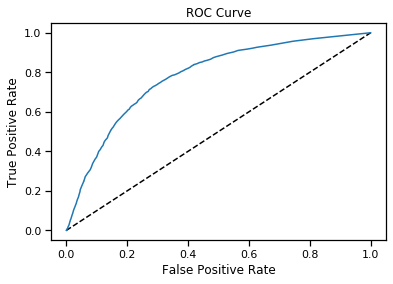

In [47]:
# Generate ROC curve values fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba)

# Plot ROC curve
_=plt.plot([0, 1], [0, 1], 'k--')
_=plt.plot(fpr, tpr)
_=plt.xlabel('False Positive Rate')
_=plt.ylabel('True Positive Rate')
_=plt.title('ROC Curve')
plt.show()

In [48]:

#obtain the feature importances from within the GridSearchCV, pipeline, & OneVsRest objects
fi = [x.feature_importances_ for x in cv.best_estimator_.steps[3][1].estimators_]
fi = np.mean(fi, axis = 0)

#place the feature importances in a dataframe
feature_importances = pd.DataFrame(fi,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.head(5)

,importance
avg_dist,0.207425
avg_rating_by_driver,0.137640
avg_rating_of_driver,0.109046
weekday_pct,0.097436
trips_in_first_30_days,0.083971


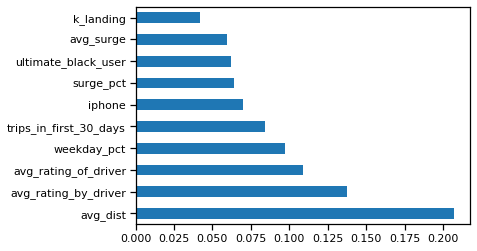

In [49]:
feat_importances = pd.Series(cv.best_estimator_.steps[3][1].feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance

My approach was to clean & explore the data, and to explore the correlations between the features. 

**Classifier:** Because of the binary classification, I chose RandomForest, GaussianNB & SVC classifiers for the pipeline.

**Pipeline:** I am using the imbPipeline, because of the imbalanced dataset. It is not largely imbalnced however, active users only make up 25% of the data.

**SimpleImputer:** to impute any of the missing values. These are primarily for the ratings features and phone types

**SMOTE:** with the imbalanced pipeline, I am able to utilize the the Synthetic Minority Over-Sampling  Technique to oversample the positive class.

**Standard Scaler:** will scale the data to have better classifier and pca performance

Performance metric chose was a blend of the *precision*. Precision will help identify true active riders to gain additional details/insight into what features are mostimportant to this group. 

A few alternatives:
- Perform a clustering algorithm to discover additional details on active users, discover if/how many rides during the week (weekday pct) does it take to become an 'active user'. This could help operaionally with a retention campagin to set a goal or metric to obtain.
    - This can also give some insight into factors that help with retention

- Switching the positive class from active to non-active (predicting non-active riders) with a **focus on recall**. With a focus on retention campaigns we can help predict which users are non-active. Recall will help find more of the pnon-active users to focus campaign efforts on, and for the active users labeled as non-active that were campaigned for additional rides, would receive a surprise and delight, and would likely boost loyalty for active users; in addition to catching more of the non-active users.

**Findings:**
- Precision score: .53 on the positive (acitve) class
- AUC - .77

**Important Features:**
- Avg Distance
- Avg Rating by the Driver
- Avg Rating of the Driver
- Weekday Pct
- Number of trips in the first 30 days

Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

**Suggestions for retention campaign efforts:**
   - retention campaign efforts focused on increasing shorter, higher number of trips, during the week (non surge times). Shifting from an 'event/need based' mindset to a convenience/regular commute' mindset.
   - Focus on service with drivers & awareness of rider ratings by driver to the rider. 
   - Increasing smaller trips during non-surge times may be a better exerience to the riders(less wait times / stress on drivers to hurry and find another fare). 

**Suggestions from an operational standpoint:**
   - Kings Landingng has a higher proportion of active users compared to Astapor and Winterfell. Retention efforts can be focused on these two cities, along with analyzing these cities with the goal of identifying key metrics that differ between these two groups.
   - iPhone vs. Android, the data suggests that iPhone users have a higher correlation with active users. Further insight is needed to identify the cause behind this.

**Note:** For data quality issues: The files were saved in different json file formats. Consistency in data management is recommended.